# Outline
1. preprocesing
    1. standardization
    1. one-hot encoding
1. Modeling
    1. LinerModel
        - Ridge
        - Lasso
    1. SVR
    1. Tree model
        - GBDT (LightGBM)
        - RandomForest 
1. Tuning of each model hyperparameter
1. Stacking
1. Ensemble

# 0.Module

In [211]:
import os
import re
import datetime
from copy import deepcopy
import numpy as np
from scipy import stats
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.svm import SVR
from sklearn.linear_model import LassoCV, RidgeCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_squared_error, make_scorer
from sklearn.model_selection import train_test_split, KFold, GridSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.feature_selection import VarianceThreshold, SequentialFeatureSelector
from sklearn.base import BaseEstimator, RegressorMixin
import lightgbm as lgb
# from lightgbm import log
from EDA import EDA
pd.options.display.precision = 2
np.set_printoptions(precision=4)

def RMSE(y_true: np.ndarray, y_pred: np.ndarray) -> np.float64:
    return np.sqrt(mean_squared_error(y_true=y_true, y_pred=y_pred))

def train_and_valied(model: BaseEstimator, X_train: pd.DataFrame=None, y_train: pd.Series=None,
                         X_test: pd.DataFrame=None, y_test: pd.Series=None, scoring: str="RMSE", aditional_kwargs: dict={}) -> BaseEstimator:
    model.fit(X=X_train, y=y_train, **aditional_kwargs)
    y_pred = model.predict(X=X_test)
    # print(f"y_pred={y_pred}")
    if scoring=="RMSE":
        score = RMSE(y_true=y_test, y_pred=y_pred)
    
    print(f"{scoring} : {score:.4f}")

    return model

# 1.preprocessing

In [174]:
train_data_raw = EDA(pd.read_csv("./data/train.csv", index_col=0, decimal=","))
train_data = EDA(pd.read_csv("./data/train_after_EDA.csv", index_col=0, decimal=","))
test_data = EDA(pd.read_csv("./data/test_after_EDA.csv", index_col=0, decimal=","))

# なぜか文字列として読み込まれてしまう特徴量を型変換
after = set(train_data.categorical_feature.columns)
before = set(train_data_raw.categorical_feature.columns)
diff_feature = after-before
for name in diff_feature:
    if name == "SalePrice":
        train_data.data[name] = train_data.data[name].astype(float)
    else:
        train_data.data[name] = train_data.data[name].astype(float)
        test_data.data[name] = test_data.data[name].astype(float)


X = deepcopy(train_data.data.drop('SalePrice', axis=1))
X['datatype'] = "train"
temp = deepcopy(test_data.data)
temp['datatype'] = "test"
X_all = pd.concat([X, temp])
y = train_data.data['SalePrice']
train_data.data = X.drop('datatype', axis=1)
train_data.set_categorical_and_numerical_feature()
test_data.set_categorical_and_numerical_feature()
train_data_raw.set_categorical_and_numerical_feature()

display(train_data.data, test_data.data, X_all)

,MSSubClass,LotFrontage,LotArea,LotShape,Neighborhood,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,...,GarageCars,GarageArea,WoodDeckSF,OpenPorchSF,MoSold,YrSold,TotalFLrSF,QualSF,BsmtVolume,meanRmsSF
Id,,,,,,,,,,,,,,,,,,,,,
1,60,4.19,9.04,Reg,CollgCr,2Story,7,5,2003,2003,...,2,548,0,61,2,2008,7.85,9.80,3424,5.37
2,20,4.39,9.17,Reg,Veenker,1Story,6,8,1976,1976,...,2,460,298,0,5,2007,7.83,9.63,5048,5.35
3,60,4.23,9.33,IR1,CollgCr,2Story,7,5,2001,2002,...,2,608,0,42,9,2008,7.90,9.85,3680,5.70
4,70,4.11,9.16,IR1,Crawfor,2Story,7,5,1915,1970,...,3,642,0,35,2,2006,7.81,9.76,2268,5.51
5,60,4.44,9.57,IR1,NoRidge,2Story,8,5,2000,2000,...,3,836,192,84,12,2008,8.11,10.19,4580,5.50
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1456,60,4.14,8.98,Reg,Gilbert,2Story,6,5,1999,2000,...,2,460,0,40,8,2007,7.86,9.66,3812,5.47
1457,20,4.45,9.49,Reg,NWAmes,1Story,6,6,1978,1988,...,2,500,349,0,2,2010,8.19,9.98,6168,5.69
1458,70,4.20,9.11,Reg,Crawfor,2Story,7,9,1941,2006,...,1,252,0,60,5,2010,8.16,10.10,3456,5.56


,MSSubClass,LotFrontage,LotArea,LotShape,Neighborhood,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,...,GarageCars,GarageArea,WoodDeckSF,OpenPorchSF,MoSold,YrSold,TotalFLrSF,QualSF,BsmtVolume,meanRmsSF
Id,,,,,,,,,,,,,,,,,,,,,
1461,20,4.39,9.36,Reg,NAmes,1Story,5,6,1961,1961,...,1.0,730.0,140,0,6,2010,7.48,9.09,2646.0,5.19
1462,20,4.41,9.57,IR1,NAmes,1Story,6,6,1958,1958,...,1.0,312.0,393,36,6,2010,7.89,9.68,3987.0,5.40
1463,60,4.32,9.53,IR1,Gilbert,2Story,5,5,1997,1998,...,2.0,482.0,212,34,3,2010,7.85,9.46,3712.0,5.61
1464,60,4.37,9.21,IR1,Gilbert,2Story,6,6,1998,1998,...,2.0,470.0,360,36,6,2010,7.84,9.63,2778.0,5.44
1465,120,3.78,8.52,IR1,StoneBr,1Story,8,5,1992,1992,...,2.0,506.0,0,82,1,2010,7.85,9.93,5120.0,5.55
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2915,160,3.09,7.57,Reg,MeadowV,2Story,4,7,1970,1970,...,0.0,0.0,0,0,6,2006,7.40,8.79,1638.0,5.39
2916,160,3.09,7.55,Reg,MeadowV,2Story,4,5,1970,1970,...,1.0,286.0,0,24,4,2006,7.40,8.79,1638.0,5.21
2917,20,5.08,9.90,Reg,Mitchel,1Story,5,7,1960,1996,...,2.0,576.0,474,0,9,2006,7.80,9.41,3672.0,5.17


,MSSubClass,LotFrontage,LotArea,LotShape,Neighborhood,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,...,GarageArea,WoodDeckSF,OpenPorchSF,MoSold,YrSold,TotalFLrSF,QualSF,BsmtVolume,meanRmsSF,datatype
Id,,,,,,,,,,,,,,,,,,,,,
1,60,4.19,9.04,Reg,CollgCr,2Story,7,5,2003,2003,...,548,0,61,2,2008,7.85,9.80,3424,5.37,train
2,20,4.39,9.17,Reg,Veenker,1Story,6,8,1976,1976,...,460,298,0,5,2007,7.83,9.63,5048,5.35,train
3,60,4.23,9.33,IR1,CollgCr,2Story,7,5,2001,2002,...,608,0,42,9,2008,7.90,9.85,3680,5.70,train
4,70,4.11,9.16,IR1,Crawfor,2Story,7,5,1915,1970,...,642,0,35,2,2006,7.81,9.76,2268,5.51,train
5,60,4.44,9.57,IR1,NoRidge,2Story,8,5,2000,2000,...,836,192,84,12,2008,8.11,10.19,4580,5.50,train
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2915,160,3.09,7.57,Reg,MeadowV,2Story,4,7,1970,1970,...,0.0,0,0,6,2006,7.40,8.79,1638.0,5.39,test
2916,160,3.09,7.55,Reg,MeadowV,2Story,4,5,1970,1970,...,286.0,0,24,4,2006,7.40,8.79,1638.0,5.21,test
2917,20,5.08,9.90,Reg,Mitchel,1Story,5,7,1960,1996,...,576.0,474,0,9,2006,7.80,9.41,3672.0,5.17,test


## 1.1One-Hot encoding

In [175]:
categorical = train_data.categorical_feature.columns
X_all = pd.get_dummies(data=X_all, columns=categorical, drop_first=True)
train = X_all.loc[X_all["datatype"]=="train", :].drop("datatype", axis=1)
test = X_all.loc[X_all["datatype"]=="test", :].drop("datatype", axis=1)
display(X_all, train, test)

,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,ExterQual,BsmtQual,...,BsmtFinType1_LwQ,BsmtFinType1_Rec,BsmtFinType1_Unf,GarageType_Attchd,GarageType_Basment,GarageType_BuiltIn,GarageType_CarPort,GarageType_Detchd,GarageFinish_RFn,GarageFinish_Unf
Id,,,,,,,,,,,,,,,,,,,,,
1,60,4.19,9.04,7,5,2003,2003,196.0,4,4,...,0,0,0,1,0,0,0,0,1,0
2,20,4.39,9.17,6,8,1976,1976,0.0,3,4,...,0,0,0,1,0,0,0,0,1,0
3,60,4.23,9.33,7,5,2001,2002,162.0,4,4,...,0,0,0,1,0,0,0,0,1,0
4,70,4.11,9.16,7,5,1915,1970,0.0,3,3,...,0,0,0,0,0,0,0,1,0,1
5,60,4.44,9.57,8,5,2000,2000,350.0,4,4,...,0,0,0,1,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2915,160,3.09,7.57,4,7,1970,1970,0.0,3,3,...,0,0,1,1,0,0,0,0,0,1
2916,160,3.09,7.55,4,5,1970,1970,0.0,3,3,...,0,1,0,0,0,0,1,0,0,1
2917,20,5.08,9.90,5,7,1960,1996,0.0,3,3,...,0,0,0,0,0,0,0,1,0,1


,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,ExterQual,BsmtQual,...,BsmtFinType1_LwQ,BsmtFinType1_Rec,BsmtFinType1_Unf,GarageType_Attchd,GarageType_Basment,GarageType_BuiltIn,GarageType_CarPort,GarageType_Detchd,GarageFinish_RFn,GarageFinish_Unf
Id,,,,,,,,,,,,,,,,,,,,,
1,60,4.19,9.04,7,5,2003,2003,196.0,4,4,...,0,0,0,1,0,0,0,0,1,0
2,20,4.39,9.17,6,8,1976,1976,0.0,3,4,...,0,0,0,1,0,0,0,0,1,0
3,60,4.23,9.33,7,5,2001,2002,162.0,4,4,...,0,0,0,1,0,0,0,0,1,0
4,70,4.11,9.16,7,5,1915,1970,0.0,3,3,...,0,0,0,0,0,0,0,1,0,1
5,60,4.44,9.57,8,5,2000,2000,350.0,4,4,...,0,0,0,1,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1456,60,4.14,8.98,6,5,1999,2000,0.0,3,4,...,0,0,1,1,0,0,0,0,1,0
1457,20,4.45,9.49,6,6,1978,1988,119.0,3,4,...,0,0,0,1,0,0,0,0,0,1
1458,70,4.20,9.11,7,9,1941,2006,0.0,5,3,...,0,0,0,1,0,0,0,0,1,0


,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,ExterQual,BsmtQual,...,BsmtFinType1_LwQ,BsmtFinType1_Rec,BsmtFinType1_Unf,GarageType_Attchd,GarageType_Basment,GarageType_BuiltIn,GarageType_CarPort,GarageType_Detchd,GarageFinish_RFn,GarageFinish_Unf
Id,,,,,,,,,,,,,,,,,,,,,
1461,20,4.39,9.36,5,6,1961,1961,0.0,3,3,...,0,1,0,1,0,0,0,0,0,1
1462,20,4.41,9.57,6,6,1958,1958,108.0,3,3,...,0,0,0,1,0,0,0,0,0,1
1463,60,4.32,9.53,5,5,1997,1998,0.0,3,4,...,0,0,0,1,0,0,0,0,0,0
1464,60,4.37,9.21,6,6,1998,1998,20.0,3,3,...,0,0,0,1,0,0,0,0,0,0
1465,120,3.78,8.52,8,5,1992,1992,0.0,4,4,...,0,0,0,1,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2915,160,3.09,7.57,4,7,1970,1970,0.0,3,3,...,0,0,1,1,0,0,0,0,0,1
2916,160,3.09,7.55,4,5,1970,1970,0.0,3,3,...,0,1,0,0,0,0,1,0,0,1
2917,20,5.08,9.90,5,7,1960,1996,0.0,3,3,...,0,0,0,0,0,0,0,1,0,1


## 1.2.standardization

In [168]:
X_train, X_valied, y_train, y_valied = train_test_split(train, y, test_size=0.2, random_state=42)
X_test = test
print(f"X_train.shape->{X_train.shape}, X_valied.shape->{X_valied.shape}, y_train.shape->{y_train.shape}, y_valied.shape->{y_valied.shape}")

scaler = StandardScaler()
numerical = train_data.numerical_feature.columns
print(numerical)
X_train.loc[:, numerical] = scaler.fit_transform(X=X_train.loc[:, numerical])
X_valied.loc[:, numerical] = scaler.transform(X_valied.loc[:, numerical])
X_test.loc[:, numerical] = scaler.transform(X=X_test.loc[:, numerical])
display(X_train, X_valied, X_test)

X_train.shape->(1164, 121), X_valied.shape->(291, 121), y_train.shape->(1164,), y_valied.shape->(291,)
Index(['MSSubClass', 'LotFrontage', 'LotArea', 'OverallQual', 'OverallCond',
       'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'ExterQual', 'BsmtQual',
       'BsmtFinSF1', 'BsmtUnfSF', 'TotalBsmtSF', 'HeatingQC', '1stFlrSF',
       '2ndFlrSF', 'GrLivArea', 'BsmtFullBath', 'FullBath', 'HalfBath',
       'BedroomAbvGr', 'KitchenQual', 'TotRmsAbvGrd', 'Fireplaces',
       'GarageYrBlt', 'GarageCars', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF',
       'MoSold', 'YrSold', 'TotalFLrSF', 'QualSF', 'BsmtVolume', 'meanRmsSF'],
      dtype='object')


,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,ExterQual,BsmtQual,...,BsmtFinType1_LwQ,BsmtFinType1_Rec,BsmtFinType1_Unf,GarageType_Attchd,GarageType_Basment,GarageType_BuiltIn,GarageType_CarPort,GarageType_Detchd,GarageFinish_RFn,GarageFinish_Unf
Id,,,,,,,,,,,,,,,,,,,,,
723,-0.87,0.16,-0.23,-1.58,1.27,-0.05,-0.74,-0.6,-0.70,-0.82,...,0,0,0,0,0,0,0,1,0,1
255,-0.87,0.16,-0.17,-0.84,0.37,-0.48,-1.37,-0.6,-0.70,-0.82,...,0,1,0,1,0,0,0,0,1,0
1067,0.07,-0.38,-0.30,-0.10,1.27,0.72,0.42,-0.6,1.04,0.64,...,0,0,1,1,0,0,0,0,1,0
639,-0.63,0.02,-0.08,-0.84,1.27,-2.05,-1.72,-0.6,-0.70,-2.29,...,0,0,1,1,0,0,0,0,0,1
1294,0.07,0.50,0.20,0.64,-0.53,0.15,-0.45,-0.6,-0.70,0.64,...,0,0,0,1,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1099,-0.17,-0.90,-0.82,-1.58,0.37,-1.18,-1.72,-0.6,-0.70,-0.82,...,0,0,0,0,0,0,0,1,0,1
1135,0.07,-0.49,-0.08,-0.10,-0.53,0.85,0.57,-0.6,-0.70,0.64,...,0,0,1,1,0,0,0,0,0,0
1300,-0.87,0.38,-0.39,-0.84,1.27,-0.42,0.42,-0.6,-0.70,-0.82,...,1,0,0,1,0,0,0,0,1,0


,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,ExterQual,BsmtQual,...,BsmtFinType1_LwQ,BsmtFinType1_Rec,BsmtFinType1_Unf,GarageType_Attchd,GarageType_Basment,GarageType_BuiltIn,GarageType_CarPort,GarageType_Detchd,GarageFinish_RFn,GarageFinish_Unf
Id,,,,,,,,,,,,,,,,,,,,,
498,-0.17,-0.33,-6.15e-03,0.64,0.37,-1.55,-1.72,-0.60,-0.70,-0.82,...,0,1,0,0,0,0,0,1,0,1
1266,2.41,-2.01,-1.75e+00,0.64,-0.53,0.92,0.67,0.67,1.04,0.64,...,0,0,0,0,0,0,0,1,0,1
412,3.12,1.28,2.60e+00,-0.84,-0.53,-0.55,-1.47,-0.60,-0.70,-0.82,...,0,1,0,1,0,0,0,0,0,0
1050,-0.87,-0.33,3.77e-01,-1.58,1.27,-0.85,1.01,-0.60,-0.70,-0.82,...,0,0,1,0,0,0,0,1,0,1
1037,-0.87,0.92,6.70e-01,2.12,-0.53,1.18,1.10,-0.19,1.04,2.11,...,0,0,0,1,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
629,0.07,0.16,4.64e-01,-0.84,-0.53,-0.08,-0.79,0.52,-0.70,0.64,...,0,1,0,1,0,0,0,0,0,1
478,0.07,1.44,7.87e-01,2.12,-0.53,1.15,1.01,3.89,2.78,0.64,...,0,0,1,0,0,1,0,0,0,0
677,0.30,-0.33,9.39e-02,-1.58,-3.23,-2.38,-1.72,-0.60,-0.70,-0.82,...,0,0,1,0,0,0,0,0,0,1


,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,ExterQual,BsmtQual,...,BsmtFinType1_LwQ,BsmtFinType1_Rec,BsmtFinType1_Unf,GarageType_Attchd,GarageType_Basment,GarageType_BuiltIn,GarageType_CarPort,GarageType_Detchd,GarageFinish_RFn,GarageFinish_Unf
Id,,,,,,,,,,,,,,,,,,,,,
1461,-0.87,0.58,0.47,-0.84,0.37,-0.35,-1.18,-0.60,-0.70,-0.82,...,0,1,0,1,0,0,0,0,0,1
1462,-0.87,0.62,0.87,-0.10,0.37,-0.45,-1.33,0.03,-0.70,-0.82,...,0,0,0,1,0,0,0,0,0,1
1463,0.07,0.33,0.81,-0.84,-0.53,0.85,0.62,-0.60,-0.70,0.64,...,0,0,0,1,0,0,0,0,0,0
1464,0.07,0.50,0.17,-0.10,0.37,0.88,0.62,-0.48,-0.70,-0.82,...,0,0,0,1,0,0,0,0,0,0
1465,1.48,-1.37,-1.18,1.38,-0.53,0.68,0.33,-0.60,1.04,0.64,...,0,0,0,1,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2915,2.41,-3.59,-3.03,-1.58,1.27,-0.05,-0.74,-0.60,-0.70,-0.82,...,0,0,1,1,0,0,0,0,0,1
2916,2.41,-3.59,-3.07,-1.58,-0.53,-0.05,-0.74,-0.60,-0.70,-0.82,...,0,1,0,0,0,0,1,0,0,1
2917,-0.87,2.78,1.53,-0.84,1.27,-0.38,0.52,-0.60,-0.70,-0.82,...,0,0,0,0,0,0,0,1,0,1


## 1.2.MinMaxscaling

In [176]:
X_train, X_valied, y_train, y_valied = train_test_split(train, y, test_size=0.2, random_state=42)
X_test = test
print(f"X_train.shape->{X_train.shape}, X_valied.shape->{X_valied.shape}, y_train.shape->{y_train.shape}, y_valied.shape->{y_valied.shape}")

scaler = MinMaxScaler()
numerical = train_data.numerical_feature.columns
print(numerical)
X_train.loc[:, numerical] = scaler.fit_transform(X=X_train.loc[:, numerical])
X_valied.loc[:, numerical] = scaler.transform(X_valied.loc[:, numerical])
X_test.loc[:, numerical] = scaler.transform(X=X_test.loc[:, numerical])
display(X_train, X_valied, X_test)

X_train.shape->(1164, 121), X_valied.shape->(291, 121), y_train.shape->(1164,), y_valied.shape->(291,)
Index(['MSSubClass', 'LotFrontage', 'LotArea', 'OverallQual', 'OverallCond',
       'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'ExterQual', 'BsmtQual',
       'BsmtFinSF1', 'BsmtUnfSF', 'TotalBsmtSF', 'HeatingQC', '1stFlrSF',
       '2ndFlrSF', 'GrLivArea', 'BsmtFullBath', 'FullBath', 'HalfBath',
       'BedroomAbvGr', 'KitchenQual', 'TotRmsAbvGrd', 'Fireplaces',
       'GarageYrBlt', 'GarageCars', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF',
       'MoSold', 'YrSold', 'TotalFLrSF', 'QualSF', 'BsmtVolume', 'meanRmsSF'],
      dtype='object')


,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,ExterQual,BsmtQual,...,BsmtFinType1_LwQ,BsmtFinType1_Rec,BsmtFinType1_Unf,GarageType_Attchd,GarageType_Basment,GarageType_BuiltIn,GarageType_CarPort,GarageType_Detchd,GarageFinish_RFn,GarageFinish_Unf
Id,,,,,,,,,,,,,,,,,,,,,
723,0.00,0.44,0.34,0.33,0.75,0.71,0.33,0.0,0.33,0.33,...,0,0,0,0,0,0,0,1,0,1
255,0.00,0.44,0.35,0.44,0.62,0.62,0.12,0.0,0.33,0.33,...,0,1,0,1,0,0,0,0,1,0
1067,0.24,0.38,0.33,0.56,0.75,0.88,0.73,0.0,0.67,0.67,...,0,0,1,1,0,0,0,0,1,0
639,0.06,0.42,0.36,0.44,0.75,0.28,0.00,0.0,0.33,0.00,...,0,0,1,1,0,0,0,0,0,1
1294,0.24,0.48,0.39,0.67,0.50,0.75,0.43,0.0,0.33,0.67,...,0,0,0,1,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1099,0.18,0.32,0.28,0.33,0.62,0.46,0.00,0.0,0.33,0.33,...,0,0,0,0,0,0,0,1,0,1
1135,0.24,0.36,0.36,0.56,0.50,0.91,0.78,0.0,0.33,0.67,...,0,0,1,1,0,0,0,0,0,0
1300,0.00,0.47,0.32,0.44,0.75,0.63,0.73,0.0,0.33,0.33,...,1,0,0,1,0,0,0,0,1,0


,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,ExterQual,BsmtQual,...,BsmtFinType1_LwQ,BsmtFinType1_Rec,BsmtFinType1_Unf,GarageType_Attchd,GarageType_Basment,GarageType_BuiltIn,GarageType_CarPort,GarageType_Detchd,GarageFinish_RFn,GarageFinish_Unf
Id,,,,,,,,,,,,,,,,,,,,,
498,0.18,0.38,0.36,0.67,0.62,0.38,0.00,0.00,0.33,0.33,...,0,1,0,0,0,0,0,1,0,1
1266,0.82,0.19,0.18,0.67,0.50,0.92,0.82,0.16,0.67,0.67,...,0,0,0,0,0,0,0,1,0,1
412,1.00,0.57,0.63,0.44,0.50,0.60,0.08,0.00,0.33,0.33,...,0,1,0,1,0,0,0,0,0,0
1050,0.00,0.38,0.40,0.33,0.75,0.54,0.93,0.00,0.33,0.33,...,0,0,1,0,0,0,0,1,0,1
1037,0.00,0.53,0.43,0.89,0.50,0.98,0.97,0.05,0.67,1.00,...,0,0,0,1,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
629,0.24,0.44,0.41,0.44,0.50,0.70,0.32,0.14,0.33,0.67,...,0,1,0,1,0,0,0,0,0,1
478,0.24,0.59,0.45,0.89,0.50,0.97,0.93,0.56,1.00,0.67,...,0,0,1,0,0,1,0,0,0,0
677,0.29,0.38,0.37,0.33,0.12,0.20,0.00,0.00,0.33,0.33,...,0,0,1,0,0,0,0,0,0,1


,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,ExterQual,BsmtQual,...,BsmtFinType1_LwQ,BsmtFinType1_Rec,BsmtFinType1_Unf,GarageType_Attchd,GarageType_Basment,GarageType_BuiltIn,GarageType_CarPort,GarageType_Detchd,GarageFinish_RFn,GarageFinish_Unf
Id,,,,,,,,,,,,,,,,,,,,,
1461,0.00,0.49,0.41,0.44,0.62,0.64,0.18,0.00,0.33,0.33,...,0,1,0,1,0,0,0,0,0,1
1462,0.00,0.49,0.45,0.56,0.62,0.62,0.13,0.08,0.33,0.33,...,0,0,0,1,0,0,0,0,0,1
1463,0.24,0.46,0.45,0.44,0.50,0.91,0.80,0.00,0.33,0.67,...,0,0,0,1,0,0,0,0,0,0
1464,0.24,0.48,0.38,0.56,0.62,0.91,0.80,0.01,0.33,0.33,...,0,0,0,1,0,0,0,0,0,0
1465,0.59,0.26,0.24,0.78,0.50,0.87,0.70,0.00,0.67,0.67,...,0,0,0,1,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2915,0.82,0.00,0.05,0.33,0.75,0.71,0.33,0.00,0.33,0.33,...,0,0,1,1,0,0,0,0,0,1
2916,0.82,0.00,0.05,0.33,0.50,0.71,0.33,0.00,0.33,0.33,...,0,1,0,0,0,0,1,0,0,1
2917,0.00,0.75,0.52,0.44,0.75,0.64,0.77,0.00,0.33,0.33,...,0,0,0,0,0,0,0,1,0,1


# 2.Modeling

## 2.1.Linear Model

### 2.1.1.Lasso

In [212]:
model_lasso = LassoCV(eps=0.01, n_alphas=100, max_iter=2000, cv=5, random_state=42, selection="random")
model_lasso = train_and_valied(model=model_lasso, X_train=X_train, y_train=y_train, X_test=X_valied, y_test=y_valied)

RMSE : 0.1284


In [187]:
coef_lasso = pd.DataFrame(data=model_lasso.coef_.reshape(-1, 1), index=X_train.columns, columns=["coef"])
coef_lasso.loc[:, "coef_abs"] = coef_lasso.loc[:, "coef"].apply(np.abs)
coef_lasso = coef_lasso.sort_values(by="coef_abs", ascending=False)
print(f"model_lasso.alpha_ -> {model_lasso.alpha_:.3f}")
display(coef_lasso.head(20))
print(f"coef is 0 -> ")
print(coef_lasso.loc[coef_lasso["coef"]==0, :].index)
print(f"coef shape -> {coef_lasso.shape}")

model_lasso.alpha_ -> 0.001


,coef,coef_abs
OverallQual,0.50,0.50
GrLivArea,0.49,0.49
OverallCond,0.29,0.29
LotArea,0.24,0.24
BsmtVolume,0.23,0.23
TotalFLrSF,0.20,0.20
YearBuilt,0.17,0.17
GarageCars,0.16,0.16
BsmtFinSF1,0.14,0.14
2ndFlrSF,0.12,0.12


coef is 0 -> 
Index(['Exterior2nd_Brk Cmn', 'Exterior1st_WdShing', 'MasVnrType_BrkFace',
       'Exterior2nd_Wd Shng', 'Exterior2nd_Wd Sdng', 'Exterior2nd_VinylSd',
       'Exterior2nd_Stucco', 'Exterior2nd_Stone', 'Exterior2nd_Plywood',
       'Exterior2nd_BrkFace', 'Exterior2nd_Other', 'Exterior2nd_AsphShn',
       'Exterior2nd_ImStucc', 'MasVnrType_None', 'Exterior2nd_CmentBd',
       'Exterior2nd_CBlock', 'Exterior2nd_HdBoard', 'LotShape_IR2',
       'Foundation_CBlock', 'BsmtFinType1_LwQ', 'GarageFinish_RFn',
       'GarageType_Detchd', 'GarageType_CarPort', 'GarageType_Basment',
       'GarageType_Attchd', 'MasVnrArea', 'BsmtFinType1_Rec',
       'BsmtFinType1_GLQ', 'Exterior1st_VinylSd', 'BsmtFinType1_BLQ',
       'BsmtUnfSF', 'BsmtExposure_Mn', 'TotalBsmtSF', 'Foundation_Wood',
       'Foundation_Stone', 'Foundation_Slab', 'FullBath', 'Exterior1st_Stone',
       'Exterior1st_Stucco', 'LotShape_IR3', 'Neighborhood_Sawyer',
       'Neighborhood_SWISU', 'OpenPorchSF', 'MoSold', 'N

### 2.1.2Ridge

In [188]:
alphas = [0.1, 1., 10., 100., 500., 1000.]
model_ridge = RidgeCV(alphas=alphas, scoring="neg_mean_squared_error", cv=5)
model_ridge = train_and_valied(model=model_ridge, X_train=X_train, y_train=y_train, X_test=X_valied, y_test=y_valied)

rmse : 0.1233


In [189]:
coef_ridge = pd.DataFrame(data=model_ridge.coef_.reshape(-1, 1), index=X_train.columns, columns=["coef"])
coef_ridge.loc[:, "coef_abs"] = coef_ridge.loc[:, "coef"].apply(np.abs)
coef_ridge = coef_ridge.sort_values(by="coef_abs", ascending=False)
print(f"model_ridge.alpha_ -> {model_ridge.alpha_}")
display(coef_ridge.head(10))
# print(f"coef is 0 -> ")
# print(coef.loc[coef["coef"]==0, :].index)
# print(f"coef shape -> {coef.shape}")

model_ridge.alpha_ -> 1.0


,coef,coef_abs
OverallQual,0.35,0.35
OverallCond,0.33,0.33
LotArea,0.30,0.30
BsmtVolume,0.26,0.26
2ndFlrSF,0.26,0.26
YearBuilt,0.26,0.26
GrLivArea,0.23,0.23
1stFlrSF,0.22,0.22
QualSF,0.19,0.19
Exterior1st_BrkComm,-0.15,0.15


## 2.2.SVR

In [208]:
#C, epsilon
param_grid = {
    "C": [0.1, 1, 10],
    "epsilon": [0.005, 0.01]
}
model_svr = GridSearchCV(SVR(), param_grid=param_grid, scoring="neg_mean_squared_error", cv=5, n_jobs=-1)
model_svr = train_and_valied(model=model_svr, X_train=X_train, y_train=y_train, X_test=X_valied, y_test=y_valied)
print(f"best params -> {model_svr.best_params_}")

RMSE : 0.1297
best params -> {'C': 1, 'epsilon': 0.01}


## 2.3.Tree Model

### 2.3.1.GBDT (LightGBM)

#### 2.3.1.1.スケール変換されたデータを使った場合

In [216]:
eval_set = [(X_valied, y_valied), (X_train, y_train)]
eval_name = ['valied', 'train']
callbacks = []
callbacks.append(lgb.early_stopping(stopping_rounds=50, verbose=False))

cv_params = {'reg_alpha': [0.0001, 0.003, 0.1],
             'reg_lambda': [0.0001, 0.1],
             'num_leaves': [2, 3, 4, 6],
             'colsample_bytree': [0.4, 0.7, 1.0],
             'subsample': [0.4, 1.0],
             'subsample_freq': [0, 7],
             'min_child_samples': [0, 2, 5, 10]
             }

fit_params = {"eval_metric":"rmse", 
              "eval_set":eval_set, 
              "eval_names":eval_name,
              "callbacks":callbacks,
              }

model_lgb = lgb.LGBMRegressor(boosting_type='gbdt', objective='regression', metric='rmse',
                      random_state=42, n_estimators=10000, importance_type='gain', learning_rate=0.01)

gridcv = GridSearchCV(estimator=model_lgb, param_grid=cv_params, n_jobs=-1, scoring="neg_mean_squared_error", cv=5)
model_lgb = train_and_valied(model=gridcv, X_train=X_train, y_train=y_train, X_test=X_valied, y_test=y_valied, aditional_kwargs=fit_params)
                      
                      
# model_lgb.fit(X_train, y_train, eval_metric="rmse", eval_set=eval_set, eval_names=eval_name ,callbacks=callbacks)


RMSE : 0.1310


In [219]:
print(f"best params -> {model_lgb.best_params_}")

best params -> {'colsample_bytree': 0.4, 'min_child_samples': 2, 'num_leaves': 6, 'reg_alpha': 0.0001, 'reg_lambda': 0.0001, 'subsample': 0.4, 'subsample_freq': 7}


<AxesSubplot:title={'center':'Metric during training'}, xlabel='Iterations', ylabel='rmse'>

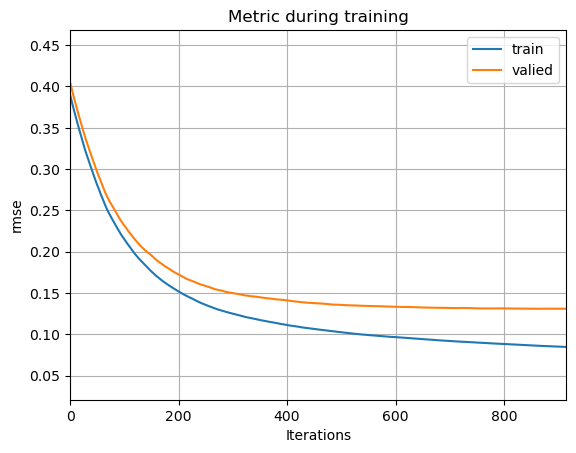

In [221]:
model_lgb_best = lgb.LGBMRegressor(boosting_type='gbdt', objective='regression', metric='rmse',
                      random_state=42, n_estimators=10000, importance_type='gain', learning_rate=0.01, **(model_lgb.best_params_))
model_lgb_best.fit(X_train, y_train, **fit_params)
lgb.plot_metric(model_lgb_best)

<AxesSubplot:title={'center':'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

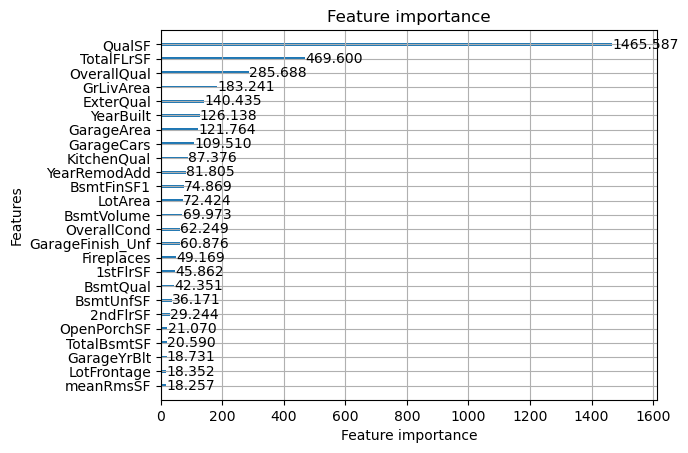

In [222]:
lgb.plot_importance(model_lgb_best, max_num_features=25)

#### 2.3.1.2.スケール変換なし

GarageYrBlt 1stFlrSF SalePrice LotArea meanRmsSF GrLivArea TotalFLrSF LotFrontage QualSF MasVnrArea 

c:\Users\miyar\anaconda3\envs\tf\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
c:\Users\miyar\anaconda3\envs\tf\lib\site-packages\lightgbm\basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


RMSE : 0.1279


<AxesSubplot:title={'center':'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

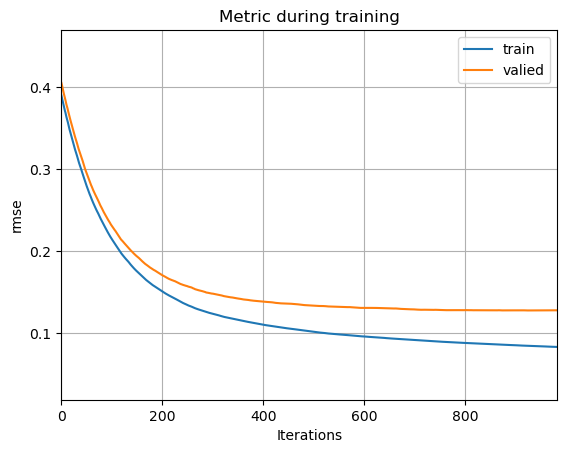

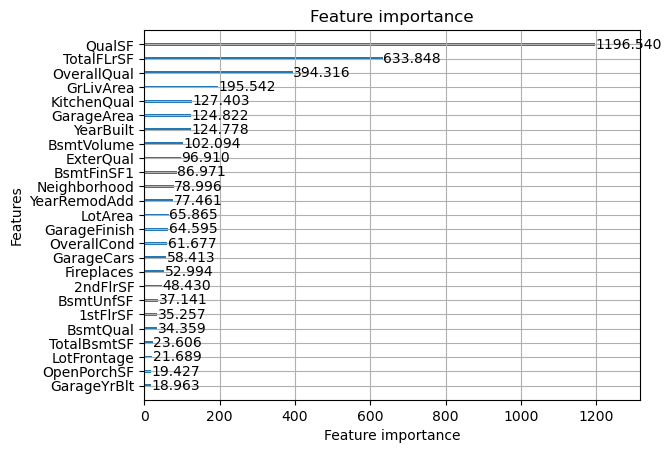

In [231]:
train_data_raw = EDA(pd.read_csv("./data/train.csv", index_col=0, decimal=","))
train_data = EDA(pd.read_csv("./data/train_after_EDA.csv", index_col=0, decimal=","))
test_data = EDA(pd.read_csv("./data/test_after_EDA.csv", index_col=0, decimal=","))

# なぜか文字列として読み込まれてしまう特徴量を型変換
after = set(train_data.categorical_feature.columns)
before = set(train_data_raw.categorical_feature.columns)
diff_feature = after-before
for name in diff_feature:
    print(name, end="  \b")
    if name == "SalePrice":
        train_data.data[name] = train_data.data[name].astype(float)
    else:
        train_data.data[name] = train_data.data[name].astype(float)
        test_data.data[name] = test_data.data[name].astype(float)
        
train_data.set_categorical_and_numerical_feature()
test_data.set_categorical_and_numerical_feature()
categorical_featre = train_data.categorical_feature.columns
train_data.data.loc[:, categorical_featre] = train_data.data.loc[:, categorical_featre].astype('category')
test_data.data.loc[:, categorical_featre] = test_data.data.loc[:, categorical_featre].astype('category')

X = deepcopy(train_data.data.drop('SalePrice', axis=1))
y = train_data.data['SalePrice']

X_train, X_valied, y_train, y_valied = train_test_split(X, y, test_size=0.2, random_state=42)
X_test = test_data.data

# temp = EDA(X_train)
# categorical_featre = temp.set_categorical_and_numerical_feature()

model_pram = {'colsample_bytree': 0.4, 'min_child_samples': 2, 'num_leaves': 6, 'reg_alpha': 0.0001, 'reg_lambda': 0.0001, 'subsample': 0.4, 'subsample_freq': 7}

eval_set = [(X_valied, y_valied), (X_train, y_train)]
eval_name = ['valied', 'train']
callbacks = []
callbacks.append(lgb.early_stopping(stopping_rounds=50, verbose=False))

fit_params = {"eval_metric":"rmse", 
              "eval_set":eval_set, 
              "eval_names":eval_name,
              "callbacks":callbacks,
              #"categorical_feature": categorical_featre,
              }

model_lgb_best = lgb.LGBMRegressor(boosting_type='gbdt', objective='regression', metric='rmse',
                      random_state=42, n_estimators=10000, importance_type='gain', learning_rate=0.01, **model_pram)

model_lgb_best = train_and_valied(model=model_lgb_best, X_train=X_train, y_train=y_train, X_test=X_valied, y_test=y_valied, aditional_kwargs=fit_params)
lgb.plot_metric(model_lgb_best)
lgb.plot_importance(model_lgb_best, max_num_features=25)

### 2.3.2.RandomForest

# 3.Tuning of each model hyperparameter

# 4.Stacking

# 5.Ensemble